In [1]:
using HDF5
using LinearAlgebra
using QuantumOptics
using Statistics
using Dates

using Plots

include("LiPoSID.jl")


(process:20936): GLib-GIO-WARNING **: 13:42:06.849: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


Main.LiPoSID

In [16]:
function get_seeds_and_timespan(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        seeds = read(fid["seeds"])
        Δt = read(fid["dt"])
        tₘₐₓ = read(fid["t_max"])
        return seeds,  Δt, tₘₐₓ
    end
end

function get_noise_levels(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        noise_levels = keys(fid["data_by_noise_level"])
        return noise_levels
    end
end

function get_variable_names(file_name, noise_level, seed)
        h5open(file_name,"r") do fid   # read file, preserve existing contents
        variable_names = keys(fid["data_by_noise_level"][string(noise_level)][string(seed)])
        return variable_names
    end
end

function get_by_name(file_name, var_name, noise_levels, seeds)
        h5open(file_name,"r") do fid # read file, preserve existing contents
        var_by_name = []
        for w in noise_levels
            current_noise_var = [ read(fid["data_by_noise_level"][string(w)][string(seed)][var_name]) for seed in seeds ]
            push!(var_by_name, current_noise_var)
        end
        return(var_by_name)
    end
end

function get_lsid(file_name, noise, seeds)
    A = get_by_name(file_name, "A", [noise], seeds)[1]
    C = get_by_name(file_name, "C", [noise], seeds)[1]
    x0 = get_by_name(file_name, "x0", [noise], seeds)[1]
    return A, C, x0
end

function get_kraus_sid(file_name, noise, seeds)  
    K1_sid = get_by_name(file_name, "K1_sid", [noise], seeds)[1]
    K2_sid = get_by_name(file_name, "K2_sid", [noise], seeds)[1]
    return K1_sid, K2_sid
end 

function get_lindblad_params(file_name, noise, key,  seeds, basis)
    H = [DenseOperator(basis, Hl) for Hl in get_by_name(file_name, "H_"*key, [noise], seeds)[1]]
    J = [DenseOperator(basis, Jl) for Jl in get_by_name(file_name, "J_"*key, [noise], seeds)[1]]
   return H, J
end

function lindblad_evolution(key, time_limit, Δt, noise_level, seed)
    time_span = [0:Δt:time_limit;]
    H_exact = DenseOperator(basis, get_by_name(file_name, "H_"*key, [noise_level], seed)[1][1])
    J_exact = DenseOperator(basis, get_by_name(file_name, "J_"*key, [noise_level], seed)[1][1])
    ρ0 = DenseOperator(basis, get_by_name(file_name, "rho0", [noise_level], seed)[1][1])
    time, ρ_exact_ser  = timeevolution.master(time_span, ρ0, H_exact, [J_exact])
    ρ = [ρₜ.data for ρₜ in ρ_exact_ser]
end

function lindblad_evolution_data(time_span, ρ0, H, J)
    time, ρ_ser  = timeevolution.master(time_span, ρ0, H, [J])
    ρ = [ρₜ.data for ρₜ in ρ_ser]
end



lindblad_evolution_data (generic function with 1 method)

In [12]:
file_name = "C:/Users/Zakhar/Documents/GitHub/JPOP_SID/LiPoSID_clust_compare_methods_started_2022-Jul-15_at_15-12.h5"
seeds,  Δt, tₘₐₓ = get_seeds_and_timespan(file_name)
noise_levels = get_noise_levels(file_name)
train_time_steps = Integer(tₘₐₓ/Δt)
@assert train_time_steps == 200
@assert mod(tₘₐₓ, Δt) < 0.01
println("Training data")
println("Noise levels:", noise_levels)
println("maximum_time: ", tₘₐₓ)
println("time_step:", Δt)
println("number of time steps:", train_time_steps)

Training data
Noise levels:["0.0", "0.01", "0.02", "0.03", "0.04", "0.05", "0.08", "0.1"]
maximum_time: 2.0
time_step:0.01
number of time steps:200


In [13]:
# Set time multiplier for forecasting
println("Forecasting parameters")
time_multiplier = 10
time_horizon = time_multiplier * tₘₐₓ
println("Time multiplier set to ", time_multiplier)
println("Time hirizon ", time_horizon)
steps_horizon = time_multiplier * train_time_steps
println("Steps horizon: ",steps_horizon)
basis = NLevelBasis(2)

Forecasting parameters
Time multiplier set to 10
Time hirizon 20.0
Steps horizon: 2000


NLevel(N=2)

In [20]:
res_file_name = "SID_fidelity_forecast_ser_" * string(Dates.format(now(), "yyyy-u-dd_at_HH-MM")) * ".h5" 
println("Results to be stored in file: " * res_file_name)

time_span = [0:Δt:time_horizon;]

@time for n in 1:length(noise_levels)
    
    noise = noise_levels[n]
    
    println("Processing noise level: " * noise)
        
    h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
    noise_group = create_group(fid, string(noise))
    end

    lk_write = ReentrantLock()
                
    ρ0 = get_by_name(file_name, "rho0", [noise], seeds)[1] 

    H_exact, J_exact = get_lindblad_params(file_name, noise, "exact",  seeds, basis)
    H_pade, J_pade = get_lindblad_params(file_name, noise, "sid_pade",  seeds, basis)
    H_simp, J_simp = get_lindblad_params(file_name, noise, "sid_simp",  seeds, basis)

    A, C, x0 = get_lsid(file_name, noise, seeds)

    K1_sid, K2_sid = get_kraus_sid(file_name, noise, seeds)
    
          
    Threads.@threads for i in 1:length(seeds[1:2]) 
      
        # Lindblad evolution selies "exact" and recovered

        ρ0q  = DenseOperator(basis, ρ0[i])
        
        ρ_exact = LiPoSID.quantum_series(basis, lindblad_evolution_data(time_span, ρ0q, H_exact[i], J_exact[i]))
        ρ_pade = LiPoSID.quantum_series(basis, lindblad_evolution_data(time_span, ρ0q, H_pade[i], J_pade[i]))
        ρ_simp = LiPoSID.quantum_series(basis,lindblad_evolution_data(time_span, ρ0q, H_simp[i], J_simp[i]))
        
        # Series recoveres by linear system identification    
   
        bloch_sid = LiPoSID.propagate(A[i], C[i], x0[i], steps_horizon)
        ρ_lsid = LiPoSID.quantum_series(basis, LiPoSID.rho_series_from_bloch(bloch_sid)) 
              
        # Series recovered with Kraus hypothesis 

        ρ_kraus = LiPoSID.quantum_series(basis, LiPoSID.timeevolution_kraus(steps_horizon, ρ0[i], [K1_sid[i], K2_sid[i]]))
               
        fid_pade = [abs(fidelity(ρ_exact[t], ρ_pade[t])) for t in 1:steps_horizon]
        fid_simp = [abs(fidelity(ρ_exact[t], ρ_simp[t])) for t in 1:steps_horizon]
        fid_lsid = [abs(fidelity(ρ_exact[t], ρ_lsid[t])) for t in 1:steps_horizon]
        fid_kraus = [abs(fidelity(ρ_exact[t], ρ_kraus[t])) for t in 1:steps_horizon]
                      
        lock(lk_write)
        
        try
            
            h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
            noise_group = open_group(fid, string(noise))
            seed_group = create_group(noise_group, string(seeds[i]))
            seed_group["fidelity_lsid"] = convert.(Float64, fid_lsid)
            seed_group["fidelity_simp"] = convert.(Float64, fid_simp)
            seed_group["fidelity_pade"] = convert.(Float64, fid_pade)
            seed_group["fidelity_kraus"] = convert.(Float64, fid_kraus)
            end
            
        finally
            unlock(lk_write)
        end

    end

end

Results to be stored in file: SID_fidelity_forecast_ser_2022-Sep-06_at_14-10.h5
Processing noise level: 0.0
Processing noise level: 0.01
Processing noise level: 0.02
Processing noise level: 0.03
Processing noise level: 0.04
Processing noise level: 0.05
Processing noise level: 0.08
Processing noise level: 0.1
 10.995967 seconds (11.28 M allocations: 1.261 GiB, 3.92% gc time, 3.12% compilation time)


In [21]:
function read_fidelities_time_series(file_name, noise, seed)
    h5open(file_name,"r") do fid # read file, preserve existing contents
        fidelity_lsid = read(fid[string(noise)][string(seed)]["fidelity_lsid"])
        fidelity_simp = read(fid[string(noise)][string(seed)]["fidelity_simp"])
        fidelity_pade = read(fid[string(noise)][string(seed)]["fidelity_pade"])
        fidelity_kraus = read(fid[string(noise)][string(seed)]["fidelity_kraus"])

        return(fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus)
    end
end
noise = "0.01"
seed = 17401799854164395076
fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus = read_fidelities_time_series(res_file_name, noise, seed)

([0.9999910648433532, 0.9999950845417395, 0.9999962219931458, 0.9999966027745124, 0.999996624983333, 0.9999964441940022, 0.9999961437713067, 0.9999957710322924, 0.9999953512356305, 0.9999948969571263  …  0.99992704239038, 0.9999269942213376, 0.9999269460509055, 0.9999268979166196, 0.9999268498169915, 0.99992680174658, 0.9999267537003391, 0.9999267056736321, 0.9999266576622224, 0.9999266096622799], [0.9999999999999997, 0.9999998817299955, 0.9999995749685037, 0.9999991412860743, 0.9999986290746052, 0.9999980748091487, 0.9999975045465744, 0.9999969356032986, 0.9999963782831516, 0.9999958375787439  …  0.999992204384517, 0.9999922042834108, 0.9999922041407759, 0.9999922040020125, 0.9999922038699665, 0.9999922037456648, 0.9999922036298685, 0.9999922035230747, 0.9999922034255191, 0.9999922033371696], [0.9999999999999997, 0.9999995748122856, 0.9999985942215429, 0.9999973927352912, 0.999996189261213, 0.9999951156116005, 0.9999942389960335, 0.9999935800938899, 0.9999931274405924, 0.9999928490351

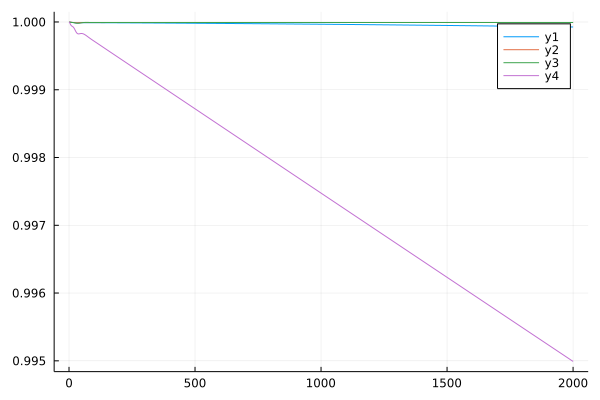

In [22]:
using Plots
plot(fidelity_lsid)
plot!(fidelity_simp)
plot!(fidelity_pade)
plot!(fidelity_kraus)